The goal of this notebook is to apply Principal Component Analysis in order to select important features from our nba dataset

Reading material:

- [pca clearly explained and when to use it](https://towardsdatascience.com/pca-clearly-explained-how-when-why-to-use-it-and-feature-importance-a-guide-in-python-7c274582c37e/?source=friends_link&sk=65bf5440e444c24aff192fedf9f8b64f)
- [step by step manually implementing and explaining](https://sebastianraschka.com/Articles/2014_pca_step_by_step.html)
- [docs page for the pca python package](https://erdogant.github.io/pca/pages/html/index.html)
    - [demo of feature importance](https://erdogant.github.io/pca/pages/html/Examples.html#demonstration-of-feature-importance)

# 1. Importing Packages and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# Set display options to show all columns and a large width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Adjust the width as needed

In [14]:
file_id = '1U2UaHWRSkUXfJBn4kBHPYttd3dvw_CZF'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, encoding='utf-8')


df.head()

,game_id,season,team_id,team_name,tri_code,team_slug,minutes,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_defensive,rebounds_total,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_offensive_rating,offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_to_turnover,assist_ratio,offensive_rebound_percentage,defensive_rebound_percentage,rebound_percentage,estimated_team_turnover_percentage,turnover_ratio,effective_field_goal_percentage,true_shooting_percentage,usage_percentage,estimated_usage_percentage,estimated_pace,pace,pace_per40,possessions,p_i_e,distance,rebound_chances_offensive,rebound_chances_defensive,rebound_chances_total,touches,secondary_assists,free_throw_assists,passes,assists,contested_field_goals_made,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game,is_playoff_game,is_regular_game
0,40400407,2004-05,1610612759,Spurs,SAS,spurs,240:00,29.0,68.0,0.426,7.0,11.0,0.636,16.0,19.0,0.842,8.0,30.0,38.0,4.0,7.0,13.0,20.0,81.0,7.0,99.6,105.2,91.2,94.9,8.4,10.3,0.483,1.08,13.5,0.317,0.696,0.517,15.978,16.9,0.478,0.530,1.0,0.201,81.26,77.5,64.58,77.0,0.542,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.426,0.0,0.0,0.0,74.0,1,1,1,0
1,40400406,2004-05,1610612759,Spurs,SAS,spurs,240:00,31.0,75.0,0.413,8.0,28.0,0.286,16.0,26.0,0.615,13.0,30.0,43.0,3.0,2.0,11.0,18.0,86.0,-9.0,100.7,107.5,119.7,117.3,-19.1,-9.8,0.484,1.25,13.2,0.383,0.696,0.538,14.045,15.0,0.467,0.497,1.0,0.197,82.40,80.5,67.08,80.0,0.408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.413,0.0,0.0,0.0,95.0,1,0,1,0
2,40400405,2004-05,1610612765,Pistons,DET,pistons,265:00,37.0,84.0,0.440,2.0,9.0,0.222,19.0,23.0,0.826,16.0,26.0,42.0,7.0,11.0,11.0,20.0,95.0,-1.0,105.4,108.0,107.6,109.1,-2.2,-1.1,0.459,1.42,13.8,0.438,0.571,0.505,13.316,13.6,0.452,0.505,1.0,0.198,81.22,79.7,66.42,88.0,0.557,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.440,0.0,0.0,0.0,96.0,1,0,1,0
3,40400404,2004-05,1610612765,Pistons,DET,pistons,240:00,41.0,90.0,0.456,2.0,9.0,0.222,18.0,23.0,0.783,13.0,34.0,47.0,13.0,6.0,3.0,22.0,102.0,31.0,111.9,117.2,82.0,80.7,29.9,36.6,0.561,5.75,18.1,0.327,0.714,0.515,4.390,4.6,0.467,0.509,1.0,0.196,88.84,87.5,72.92,87.0,0.736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.456,0.0,0.0,0.0,71.0,1,1,1,0
4,40400403,2004-05,1610612765,Pistons,DET,pistons,240:00,40.0,85.0,0.471,3.0,14.0,0.214,13.0,17.0,0.765,17.0,27.0,44.0,12.0,10.0,11.0,18.0,96.0,17.0,109.7,115.7,94.3,95.2,15.5,20.5,0.550,1.83,17.4,0.429,0.683,0.544,13.717,14.5,0.488,0.519,1.0,0.193,85.64,83.0,69.17,83.0,0.640,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471,0.0,0.0,0.0,79.0,1,1,1,0


## 1.2 Filtering down df 

So we discovered that many of the columns (like `touches`,`passes`,`assists`, etc) have a 0 for games prior the `2013-14` season. It is likely that those stats were not being tracked then but have elected to do the following (intentionally overwriting `df`):
- ~~keep only regular and playoff games~~
- keep games from `2013-14` season and onward

In [ ]:
# shape_before = df.shape

# # Making df consist only of regular and playoff games
# df_regular_games = df.loc[df['is_regular_game'] == 1]
# df_playoff_games = df.loc[df['is_playoff_game'] == 1]
# df = pd.concat([df_playoff_games, df_playoff_games], ignore_index=True)

# print(f'Shape before: {shape_before}\n Shape after concat regular and playoff: {df.shape}')

The following function should add an indicator column for simple subset of games past `2013-14` season

In [5]:
def has_acceptable_season(row):
    acceptable_seasons = [
        '2013-14',
        '2014-15',
        '2015-16',
        '2016-17',
        '2017-18',
        '2018-19',
        '2019-20',
        '2020-21',
        '2021-22',
        '2022-23',
        '2023-24'
    ]
    if row['season'] in acceptable_seasons:
        return 1
    else:
        return 0

Using the function and subsetting for when `acceptable_season` == 1 results in the following

In [15]:
shape_before = df.shape

df['acceptable_season'] = df.apply(has_acceptable_season, axis=1)
df = df.loc[df['acceptable_season'] == 1]

print(f'Shape before filtering for acceptable_season: {shape_before}\n Shape after filtering for acceptable_season: {df.shape}')

Shape before filtering for acceptable_season: (55314, 72)
 Shape after filtering for acceptable_season: (30324, 73)


Dropping the `acceptable_season` column since it was only created and needed for this section

In [ ]:
df = df.drop(columns=['acceptable_season'])

# 2. Preprocess data

Before running PCA we need to:
1. Drop obvious non numeric columns
2. Decide which and drop dummy variables
3. Handle missing values
4. Standardize the numeric features (since PCA works best with standardized data)  

**Step 1. Drop the obvious/non numeric columns**
- `game_id`
- `season`
- `team_id`
- `team_name`
- `tri_code`
- `team_slug`
- `minutes`: right now is a string like object





In [18]:
drop_cols1 = [
    'game_id',
    'season',
    'team_id',
    'team_name',
    'tri_code',
    'team_slug',
    'minutes'
]

df = df.drop(columns=drop_cols1)

**Step 2. Decide and drop dummy variables**

Going to check the variance of each dummy variable since if the variance is close to 0 it wont really contribute much to PCA and can be dropped

In [19]:
df[['is_home_team', 'won_game', 'is_playoff_game', 'is_regular_game']].var()

is_home_team       0.250008
won_game           0.250008
is_playoff_game    0.056998
is_regular_game    0.112221
dtype: float64

Since .25 is the maximum variance possible for binary dummy variable we'll keep `is_home_team` and `won_game` and drop `is_playoff_game` and `is_regular_game`

In [20]:
drop_cols3 = [
    'is_playoff_game',
    'is_regular_game'
]

df = df.drop(columns=drop_cols3)

At this point `df` should only have numeric colums and will be renamed to `df_num` 

In [21]:
df_num = df
df_num.head()

,field_goals_made,field_goals_attempted,field_goals_percentage,three_pointers_made,three_pointers_attempted,three_pointers_percentage,free_throws_made,free_throws_attempted,free_throws_percentage,rebounds_offensive,rebounds_defensive,rebounds_total,steals,blocks,turnovers,fouls_personal,points,plus_minus_points,estimated_offensive_rating,offensive_rating,estimated_defensive_rating,defensive_rating,estimated_net_rating,net_rating,assist_percentage,assist_to_turnover,assist_ratio,offensive_rebound_percentage,defensive_rebound_percentage,rebound_percentage,estimated_team_turnover_percentage,turnover_ratio,effective_field_goal_percentage,true_shooting_percentage,usage_percentage,estimated_usage_percentage,estimated_pace,pace,pace_per40,possessions,p_i_e,distance,rebound_chances_offensive,rebound_chances_defensive,rebound_chances_total,touches,secondary_assists,free_throw_assists,passes,assists,contested_field_goals_made,contested_field_goals_attempted,contested_field_goal_percentage,uncontested_field_goals_made,uncontested_field_goals_attempted,uncontested_field_goals_percentage,field_goal_percentage,defended_at_rim_field_goals_made,defended_at_rim_field_goals_attempted,defended_at_rim_field_goal_percentage,opponent_points,is_home_team,won_game
12495,37.0,78.0,0.474,12.0,26.0,0.462,18.0,23.0,0.783,6.0,34.0,40.0,5.0,4.0,8.0,21.0,104.0,17.0,115.4,116.9,92.7,97.8,22.7,19.1,0.676,3.13,20.6,0.178,0.750,0.473,8.877,9.0,0.551,0.590,1.0,0.200,92.00,89.0,74.17,89.0,0.622,17.60,32.0,61.0,90.0,467.0,4.0,1.0,357.0,25.0,18.0,38.0,0.474,19.0,40.0,0.475,0.474,15.0,24.0,0.625,87.0,1,1
12496,32.0,71.0,0.451,9.0,22.0,0.409,13.0,20.0,0.650,6.0,21.0,27.0,7.0,1.0,13.0,25.0,86.0,-21.0,99.1,101.2,128.9,127.4,-29.8,-26.2,0.406,1.00,12.3,0.000,0.000,0.000,14.977,15.3,0.514,0.539,1.0,0.203,84.90,84.5,70.42,85.0,0.297,16.83,21.0,38.0,57.0,377.0,0.0,1.0,274.0,13.0,14.0,30.0,0.467,18.0,41.0,0.439,0.451,16.0,19.0,0.842,107.0,1,0
12497,32.0,62.0,0.516,10.0,21.0,0.476,18.0,24.0,0.750,5.0,21.0,26.0,8.0,1.0,20.0,26.0,92.0,-19.0,105.1,108.2,128.9,129.1,-23.9,-20.8,0.531,0.85,15.5,0.229,0.733,0.462,22.841,23.5,0.597,0.634,1.0,0.199,86.82,85.5,71.25,85.0,0.365,16.36,21.0,40.0,57.0,361.0,2.0,0.0,256.0,17.0,16.0,31.0,0.516,16.0,31.0,0.516,0.516,14.0,20.0,0.700,111.0,1,0
12498,36.0,82.0,0.439,12.0,26.0,0.462,12.0,20.0,0.600,11.0,26.0,37.0,7.0,1.0,11.0,20.0,96.0,-2.0,105.7,109.1,108.6,110.1,-2.9,-1.0,0.722,2.36,20.3,0.260,0.000,0.000,12.115,12.5,0.512,0.529,1.0,0.196,90.52,88.5,73.75,88.0,0.478,16.80,25.0,37.0,60.0,436.0,6.0,1.0,325.0,26.0,17.0,40.0,0.425,19.0,42.0,0.452,0.439,17.0,24.0,0.708,98.0,1,0
12499,40.0,68.0,0.588,13.0,25.0,0.520,17.0,22.0,0.773,5.0,34.0,39.0,8.0,4.0,22.0,14.0,110.0,15.0,115.0,115.8,101.2,100.0,13.7,15.8,0.750,1.30,23.0,0.258,0.814,0.581,24.038,24.2,0.684,0.708,1.0,0.199,94.76,95.0,79.17,95.0,0.626,17.48,17.0,57.0,72.0,441.0,2.0,3.0,333.0,30.0,23.0,32.0,0.719,17.0,36.0,0.472,0.588,12.0,21.0,0.571,95.0,1,1


This is tmp experiment code to see if exluding rows where 0's for specific columns dont make sense significantly impacts the most important features

In [58]:
df_num = df_num.loc[df_num['opponent_points'] != 0].loc[df_num['distance'] != 0]

**Step 3. Handle missing values**

A prior notebook somehwere has the code for why dropping instead of imputing is fine

In [59]:
shape_before = df_num.shape
df_num = df_num.dropna()

print(f'Shape before dropping nas: {shape_before}\n Shape after dropping nas: {df_num.shape}')

Shape before dropping nas: (28192, 63)
 Shape after dropping nas: (28192, 63)


**Step 4. Standardize numeric features**

We will be using `StandardScaler` from scikit learn for this ([docs link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler))

In [60]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_num)

# convert back to dataframe
df_scaled = pd.DataFrame(df_scaled, columns=df_num.columns)

# 3. Running PCA

## via scikit learn

Looked over the sklearn docs page once more and thought to try using svd with variance based `n_components` parameter (0 < value < 1)

https://scikit-learn.org/1.6/modules/generated/sklearn.decomposition.PCA.html 

Initialize, fit, and train PCA() class. Looking for features that cumulativate account for at least 90% of the variance in the dataset 

In [61]:
model = PCA(
    n_components=0.9,   # Change this value if looking to reduce to specific number of components or different cumulative variance explained 
    svd_solver='full'
).fit(df_scaled)

result = model.transform(df_scaled)

The following bit uses list comprehension to construct a dataframe of the most imporant features for convenience

In [62]:
# number of components
n_pcs = model.components_.shape[0]

# get the index of the most important feature on EACH component
most_important = [np.abs(model.components_[i]).argmax() for i in range (n_pcs)]

# grab all the column names
col_names = list(df_num.columns)

# use columm names to identify the most important features
most_important_names =  [col_names[most_important[i]] for i in range(n_pcs)]

tmp = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# use the tmp dictionary to fill up a dataframe
important_features_df = pd.DataFrame(tmp.items())
print(important_features_df)




       0                                      1
0    PC0        effective_field_goal_percentage
1    PC1                        opponent_points
2    PC2                            possessions
3    PC3     estimated_team_turnover_percentage
4    PC4             contested_field_goals_made
5    PC5                       free_throws_made
6    PC6           offensive_rebound_percentage
7    PC7                       free_throws_made
8    PC8                     rebound_percentage
9    PC9                                 steals
10  PC10  defended_at_rim_field_goals_attempted
11  PC11                      assist_percentage
12  PC12           defensive_rebound_percentage
13  PC13                 free_throws_percentage
14  PC14                 free_throws_percentage
15  PC15                           is_home_team
16  PC16             estimated_usage_percentage
17  PC17                           is_home_team
18  PC18             estimated_usage_percentage


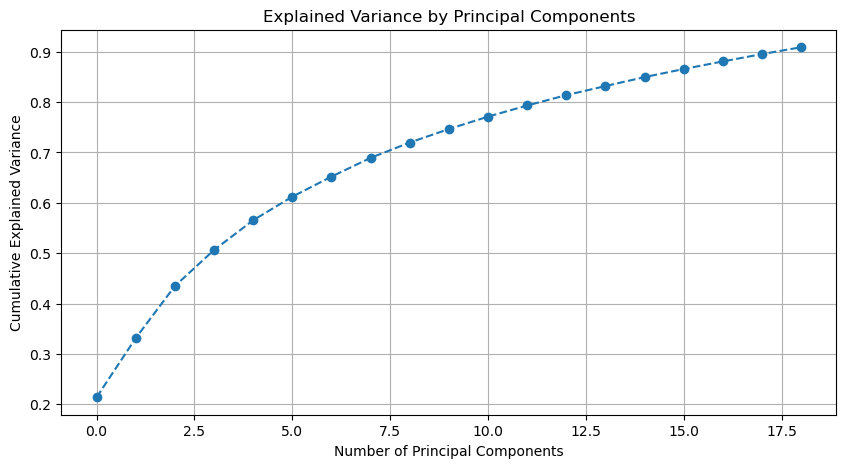

1

In [63]:
explained_variance = model.explained_variance_ratio_

# plot cumulative explained variance
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.show()

# find number of components to explain 95% variance
num_components = np.argmax(np.cumsum(explained_variance) >= 0.95) + 1

# number of components needed to retain 95% variance
num_components

In [64]:
len(model.components_[0])

63

## via pca library

In [65]:
from pca import pca

[pca] >Extracting column labels from dataframe.
[pca] >Extracting row labels from dataframe.
[pca] >The PCA reduction is performed to capture [90.0%] explained variance using the [63] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [19] that covers the [90.00%] explained variance.
[pca] >The PCA reduction is performed on the [63] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[19]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 19 Principal Components explain [92.11%] of the variance.'}, xlabel='Principal Component', ylabel='Percentage explained variance'>)

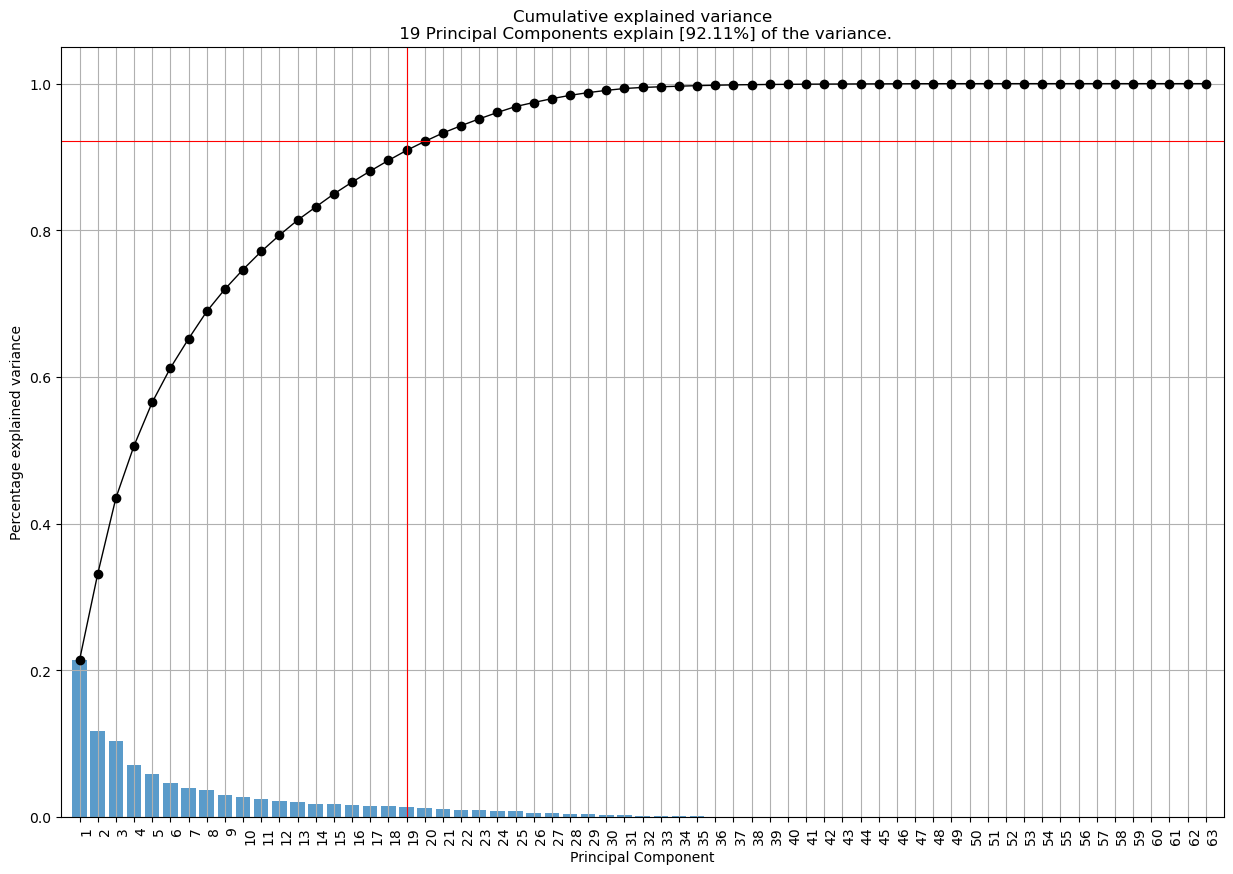

In [66]:
model_2 = pca(n_components=0.9)
result_2 = model_2.fit_transform(df_scaled)

model_2.plot()

In [67]:
result_2['topfeat'].loc[result_2['topfeat']['type'] == 'best']

,PC,feature,loading,type
0,PC1,effective_field_goal_percentage,0.248750,best
1,PC2,opponent_points,0.341910,best
2,PC3,possessions,0.310156,best
3,PC4,estimated_team_turnover_percentage,0.410188,best
4,PC5,contested_field_goals_made,0.333335,best
5,PC6,free_throws_made,0.274041,best
6,PC7,offensive_rebound_percentage,0.391880,best
7,PC8,free_throws_made,0.391099,best
8,PC9,rebound_percentage,0.446926,best
9,PC10,steals,0.567492,best


In [68]:
set(result_2['topfeat'].loc[result_2['topfeat']['type'] == 'best']['feature'].to_list())

{'assist_percentage',
 'contested_field_goals_made',
 'defended_at_rim_field_goals_attempted',
 'defensive_rebound_percentage',
 'effective_field_goal_percentage',
 'estimated_team_turnover_percentage',
 'estimated_usage_percentage',
 'free_throws_made',
 'free_throws_percentage',
 'is_home_team',
 'offensive_rebound_percentage',
 'opponent_points',
 'possessions',
 'rebound_percentage',
 'steals'}

## Conclusion

Unique column names from pca method 1

In [73]:
set(important_features_df[1].to_list())

{'assist_percentage',
 'contested_field_goals_made',
 'defended_at_rim_field_goals_attempted',
 'defensive_rebound_percentage',
 'effective_field_goal_percentage',
 'estimated_team_turnover_percentage',
 'estimated_usage_percentage',
 'free_throws_made',
 'free_throws_percentage',
 'is_home_team',
 'offensive_rebound_percentage',
 'opponent_points',
 'possessions',
 'rebound_percentage',
 'steals'}

unique column names from pca method 2

In [70]:
set(result_2['topfeat'].loc[result_2['topfeat']['type'] == 'best']['feature'].to_list())

{'assist_percentage',
 'contested_field_goals_made',
 'defended_at_rim_field_goals_attempted',
 'defensive_rebound_percentage',
 'effective_field_goal_percentage',
 'estimated_team_turnover_percentage',
 'estimated_usage_percentage',
 'free_throws_made',
 'free_throws_percentage',
 'is_home_team',
 'offensive_rebound_percentage',
 'opponent_points',
 'possessions',
 'rebound_percentage',
 'steals'}

---

From attempt 1
```
{'assist_percentage',
 'blocks',
 'distance',
 'estimated_offensive_rating',
 'estimated_team_turnover_percentage',
 'estimated_usage_percentage',
 'free_throws_made',
 'free_throws_percentage',
 'is_home_team',
 'offensive_rebound_percentage',
 'opponent_points',
 'possessions',
 'rebound_percentage',
 'steals'}
```

 From attempt 2 (added experiemental code to exclude rows where 0 in a couple specific columns doesnt make sense)
```
{'assist_percentage',
 'contested_field_goals_made',
 'defended_at_rim_field_goals_attempted',
 'defensive_rebound_percentage',
 'effective_field_goal_percentage',
 'estimated_team_turnover_percentage',
 'estimated_usage_percentage',
 'free_throws_made',
 'free_throws_percentage',
 'is_home_team',
 'offensive_rebound_percentage',
 'opponent_points',
 'possessions',
 'rebound_percentage',
 'steals'}
 ```

In [76]:
a = ['assist_percentage',
 'blocks',
 'distance',
 'estimated_offensive_rating',
 'estimated_team_turnover_percentage',
 'estimated_usage_percentage',
 'free_throws_made',
 'free_throws_percentage',
 'is_home_team',
 'offensive_rebound_percentage',
 'opponent_points',
 'possessions',
 'rebound_percentage',
 'steals']

b = ['assist_percentage',
 'contested_field_goals_made',
 'defended_at_rim_field_goals_attempted',
 'defensive_rebound_percentage',
 'effective_field_goal_percentage',
 'estimated_team_turnover_percentage',
 'estimated_usage_percentage',
 'free_throws_made',
 'free_throws_percentage',
 'is_home_team',
 'offensive_rebound_percentage',
 'opponent_points',
 'possessions',
 'rebound_percentage',
 'steals']

set(a).intersection(set(b))


{'assist_percentage',
 'estimated_team_turnover_percentage',
 'estimated_usage_percentage',
 'free_throws_made',
 'free_throws_percentage',
 'is_home_team',
 'offensive_rebound_percentage',
 'opponent_points',
 'possessions',
 'rebound_percentage',
 'steals'}

In [77]:
set(a).union(set(b))

{'assist_percentage',
 'blocks',
 'contested_field_goals_made',
 'defended_at_rim_field_goals_attempted',
 'defensive_rebound_percentage',
 'distance',
 'effective_field_goal_percentage',
 'estimated_offensive_rating',
 'estimated_team_turnover_percentage',
 'estimated_usage_percentage',
 'free_throws_made',
 'free_throws_percentage',
 'is_home_team',
 'offensive_rebound_percentage',
 'opponent_points',
 'possessions',
 'rebound_percentage',
 'steals'}

In [ ]:
# # manually compiled from Attempt 1 and Attempt 2

# cols = [
#     'assist_percentage',
#     'blocks',
#     'distance',
#     'free_throws_made',
#     'free_throws_attempted',
#     'opponent_points',
#     'possessions',
#     'rebound_percentage',
#     'defensive_rebound_percentage',
#     'offensive_rebound_percentage'
#     'steals',
#     'contested_field_goals_made',
#     'defended_at_rim_field_goals_attempted',
#     'is_home_team',

#     'estimated_team_turnover_percentage',
#     'estimated_usage_percentage'
# ]